# Signal and noise histograms (from simtel files)

In [21]:
%matplotlib inline

import numpy as np
import scipy
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 8)

import json

import ctapipe
from ctapipe.io.hessio import hessio_event_source
import pyhessio

#ctapipe.version.get_version()
print(ctapipe.__version__)
print(pyhessio.__version__)

from ctapipe.instrument import CameraGeometry

# calibrator
from ctapipe.calib import CameraCalibrator

calib = CameraCalibrator(None, None)

0.5.1
2.0.1


In [2]:
MAX_NUM_SAMPLES = 50000000

## Common functions

In [3]:
def plot_all_and_save_cdf(simtel_file,
                          tel_id_filter_list,
                          channel_threshold,
                          cam_id,
                          json_file_path,
                          max_num_samples=1000000):

    print("Cam ID:", cam_id)
    print("Simtel file:", simtel_file)
    print("Tel ID range:", tel_id_filter_list)

    source = hessio_event_source(simtel_file, allowed_tels=tel_id_filter_list)

    #in_sample_list = []
    sig_sample_list = []
    #noise_sample_list = []
    noise2_sample_list = []
    
    # ITERATE OVER EVENTS #############################################

    for ev in source:

        if (len(sig_sample_list)) > 0 and (len(sig_sample_list) * len(sig_sample_list[0]) >= max_num_samples):
            break
        
        calib.calibrate(ev)  # calibrate the event
        
        # ITERATE OVER IMAGES #########################################

        for tel_id in ev.trig.tels_with_trigger:
            
            if (len(sig_sample_list)) > 0 and (len(sig_sample_list) * len(sig_sample_list[0]) >= max_num_samples):
                break

            tel_id = int(tel_id)

            if tel_id in tel_id_filter_list:

                # CHECK THE IMAGE GEOMETRY ############################

                x, y = ev.inst.pixel_pos[tel_id]
                foclen = ev.inst.optical_foclen[tel_id]
                geom = ctapipe.instrument.CameraGeometry.guess(x, y, foclen)

                if geom.cam_id != cam_id:
                    raise ValueError("Telescope {}: error (the input image is not a valide {} telescope image but a {} telescope image)".format(tel_id, cam_id, geom.cam_id))

                # GET IMAGES ##########################################

                pe_image = ev.mc.tel[tel_id].photo_electron_image  # 1D np array
                #uncalibrated_image = ev.r0.tel[tel_id].adc_sums   # ctapipe 0.4.0
                #pedestal = ev.mc.tel[tel_id].pedestal
                #gain = ev.mc.tel[tel_id].dc_to_pe
                #pixel_pos = ev.inst.pixel_pos[tel_id]
                calibrated_image = ev.dl1.tel[tel_id].image
                
                if channel_threshold is not None:
                    # 2 channels
                    calibrated_image[1, calibrated_image[0,:] <= channel_threshold] = 0
                    calibrated_image[0, calibrated_image[0,:] >  channel_threshold] = 0
                    calibrated_image = calibrated_image.sum(axis=0)
                else:
                    # 1 channel
                    calibrated_image = calibrated_image[0]
                
                # ADD SAMPLES #########################################

                #in_sample_list.append(calibrated_image)
                sig_sample_list.append(pe_image)
                #noise_sample_list.append(calibrated_image - pe_image)
                noise2_sample_list.extend(calibrated_image[pe_image == 0.].tolist())

    #in_sample_array = np.array(in_sample_list).ravel()
    
    sig_sample_array = np.array(sig_sample_list).ravel()
    del sig_sample_list
    
    #noise_sample_array = np.array(noise_sample_list).ravel()
    
    noise2_sample_array = np.array(noise2_sample_list)
    del noise2_sample_list
    
    # MAKE THE CDF ####################################################
    
    hist_y, cdf_x = np.histogram(noise2_sample_array, bins=100, density=False)
    cum_hist_y = hist_y.cumsum()
    cum_hist_y_max = cum_hist_y.max()
    cdf_y = cum_hist_y / cum_hist_y_max
    cdf_x = cdf_x[:-1]

    # PLOT ############################################################
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(14, 14))
    
    num_bins = 100
    
    print("Num samples:", len(sig_sample_array))
    print("Memory usage for sig_sample_array: {} Mb".format(sig_sample_array.nbytes / 1000000.))
    print("Memory usage for noise2_sample_array: {} Mb".format(noise2_sample_array.nbytes / 1000000.))
    
    #plt.hist(in_sample_array, bins=num_bins, range=(-10, 2500), log=True);

    ax1.hist(sig_sample_array,
             bins=num_bins,
             range=(-10, 2500),
             log=True)

    #plt.hist(noise_sample_array,
    #         bins=num_bins,
    #         range=(-50, 50),
    #         log=False);

    ax2.hist(noise2_sample_array,
             bins=num_bins,
             #range=(-10, 50),
             log=False)
    
    ax3.plot(cdf_x, hist_y / cum_hist_y_max, "-r")
    ax3.plot(cdf_x[1:], np.diff(cdf_y), "-b")
    
    ax4.plot(cdf_x, cdf_y)
    
    print("Noise: Mean = {} ; Std = {}".format(noise2_sample_array.mean(), noise2_sample_array.std()))
    print("Min:", noise2_sample_array.min())
    print("Max:", noise2_sample_array.max())
    
    json_data = {'cdf_x': cdf_x.tolist(),
                 'cdf_y': cdf_y.tolist(),
                 'inst': cam_id,
                 'channel_threshold': channel_threshold,
                 'simtel_file': simtel_file,
                 'tel_id_filter_list': tel_id_filter_list,
                 'num_samples': len(sig_sample_array)}

    with open(json_file_path, "w") as fd:
        json.dump(json_data, fd, sort_keys=True, indent=4)  # pretty print format

## ASTRI

### INAF's ASTRI mini array

ASTRI = "ASTRICam" (tel 1 to 33 in astri mini array), 2 channels

Cam ID: ASTRICam
Simtel file: /Users/jdecock/vm-shared/data/astri_mini_array/simtel/gamma/run1001.simtel.gz
Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Num samples: 35280832
Memory usage for sig_sample_array: 141.123328 Mb
Memory usage for noise2_sample_array: 273.958416 Mb
Noise: Mean = 0.8085954656291242 ; Std = 0.5453897527629348
Min: -1.10314574294
Max: 5.55022277574
CPU times: user 13min 17s, sys: 12.3 s, total: 13min 29s
Wall time: 13min 39s


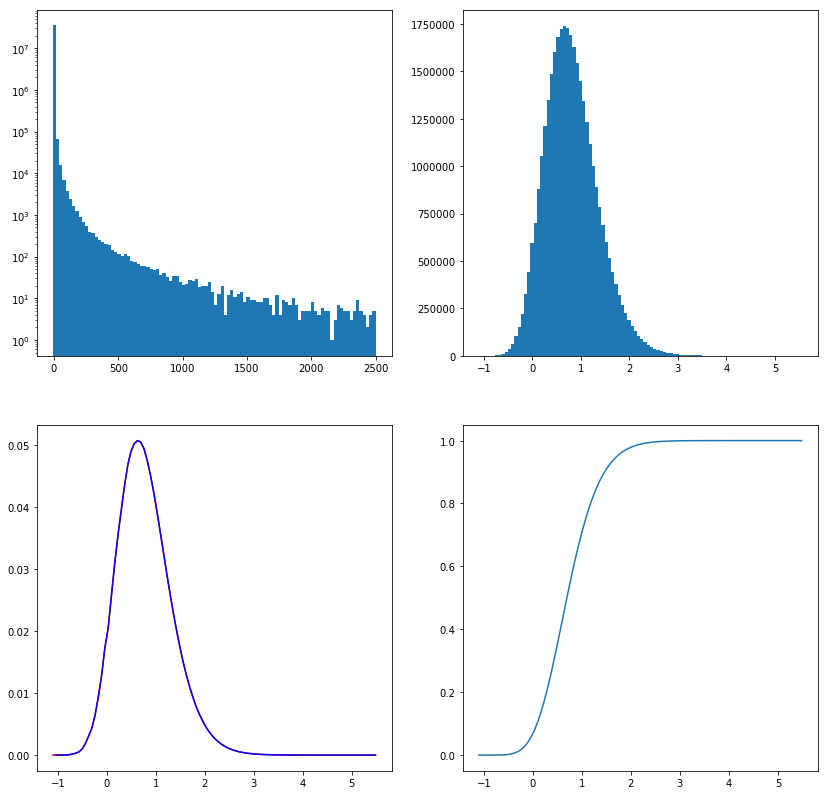

In [4]:
%%time

channel_threshold = 14   # FYI Tino uses 14

gamma_file_path =  "/Users/jdecock/vm-shared/data/astri_mini_array/simtel/gamma/run1001.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/astri_mini_array/simtel/proton/run10001.simtel.gz"

plot_all_and_save_cdf(gamma_file_path,
                      tel_id_filter_list=list(range(1, 34)),
                      channel_threshold=channel_threshold,
                      cam_id="ASTRICam",
                      json_file_path="astri_inaf_cdf.json",
                      max_num_samples=MAX_NUM_SAMPLES)

### Konrad's ASTRI mini array

ASTRI = "ASTRICam" (tel 1 to 16 in astri mini array), 2 channels

Cam ID: ASTRICam
Simtel file: /Users/jdecock/vm-shared/data/astri_mini_array_konrad/simtel/astri_v2/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-astri_desert-2150m-Paranal-sst-astri2.simtel.gz
Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Num samples: 50000320
Memory usage for sig_sample_array: 200.00128 Mb
Memory usage for noise2_sample_array: 389.24476 Mb
Noise: Mean = 0.8085052872791622 ; Std = 0.5454200503427687
Min: -1.12773744612
Max: 5.99559357672
CPU times: user 18min 54s, sys: 29.7 s, total: 19min 24s
Wall time: 19min 28s


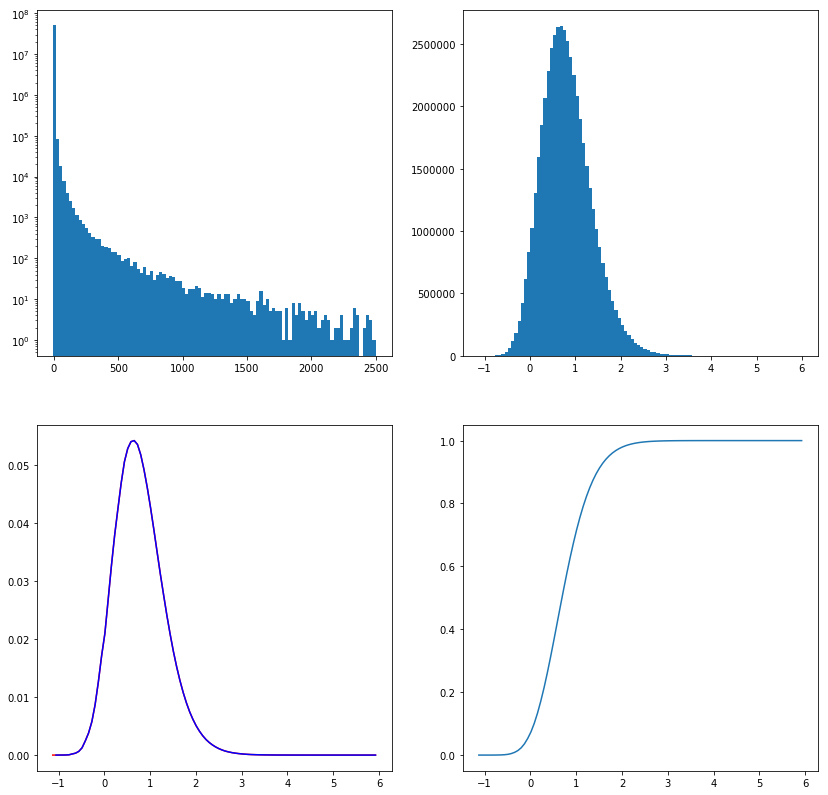

In [5]:
%%time

channel_threshold = 14   # FYI Tino uses 14

gamma_file_path =  "/Users/jdecock/vm-shared/data/astri_mini_array_konrad/simtel/astri_v2/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-astri_desert-2150m-Paranal-sst-astri2.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/astri_mini_array_konrad/simtel/astri_v2/proton/proton_20deg_180deg_run4003___cta-prod3-sst-astri_desert-2150m-Paranal-sst-astri2.simtel.gz"

plot_all_and_save_cdf(gamma_file_path,
                      tel_id_filter_list=list(range(1, 17)),
                      channel_threshold=channel_threshold,
                      cam_id="ASTRICam",
                      json_file_path="astri_konrad_cdf.json",
                      max_num_samples=MAX_NUM_SAMPLES)

## Flashcam

### INAF's ASTRI mini array

FlashCam = "FlashCam" (tel 34 to 38 in prod3b - North site (LaPalma)), 1 channel

Cam ID: FlashCam
Simtel file: /Users/jdecock/vm-shared/data/astri_mini_array/simtel/gamma/run1001.simtel.gz
Tel ID range: [34, 35, 36, 37, 38]
Num samples: 20756988
Memory usage for sig_sample_array: 83.027952 Mb
Memory usage for noise2_sample_array: 158.771024 Mb
Noise: Mean = 0.020659855969215067 ; Std = 3.382438622306341
Min: -10.7659183817
Max: 36.8351427354
CPU times: user 8min 38s, sys: 4.89 s, total: 8min 43s
Wall time: 8min 54s


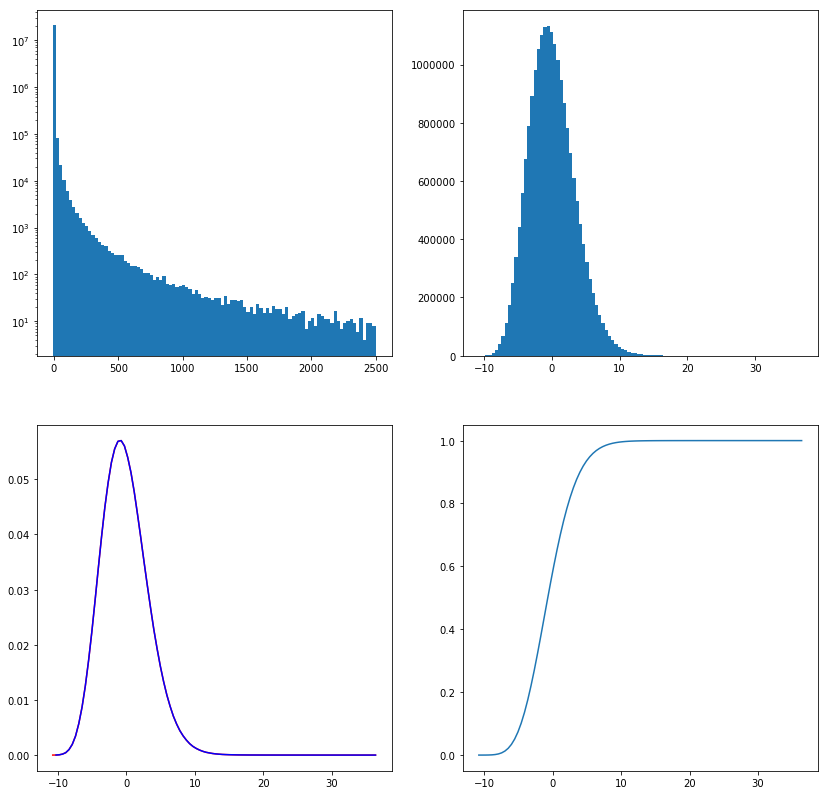

In [6]:
%%time

gamma_file_path =  "/Users/jdecock/vm-shared/data/astri_mini_array/simtel/gamma/run1001.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/astri_mini_array/simtel/proton/run10001.simtel.gz"

plot_all_and_save_cdf(gamma_file_path,
                      tel_id_filter_list=list(range(34, 39)),
                      channel_threshold=None,
                      cam_id="FlashCam",
                      json_file_path="flashcam_inaf_cdf.json",
                      max_num_samples=MAX_NUM_SAMPLES)

### Grid Prod3b North

FlashCam = "FlashCam" (tel 9 to 42 and 111 to 115 in prod3b - North site (LaPalma)), 1 channel

Cam ID: FlashCam
Simtel file: /Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz
Tel ID range: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 111, 112, 113, 114, 115]
Num samples: 24186204
Memory usage for sig_sample_array: 96.744816 Mb
Memory usage for noise2_sample_array: 186.292488 Mb
Noise: Mean = 0.022376945693221472 ; Std = 3.3846434802894634
Min: -10.7162781551
Max: 37.1786521496
CPU times: user 10min 25s, sys: 8.14 s, total: 10min 33s
Wall time: 12min 24s


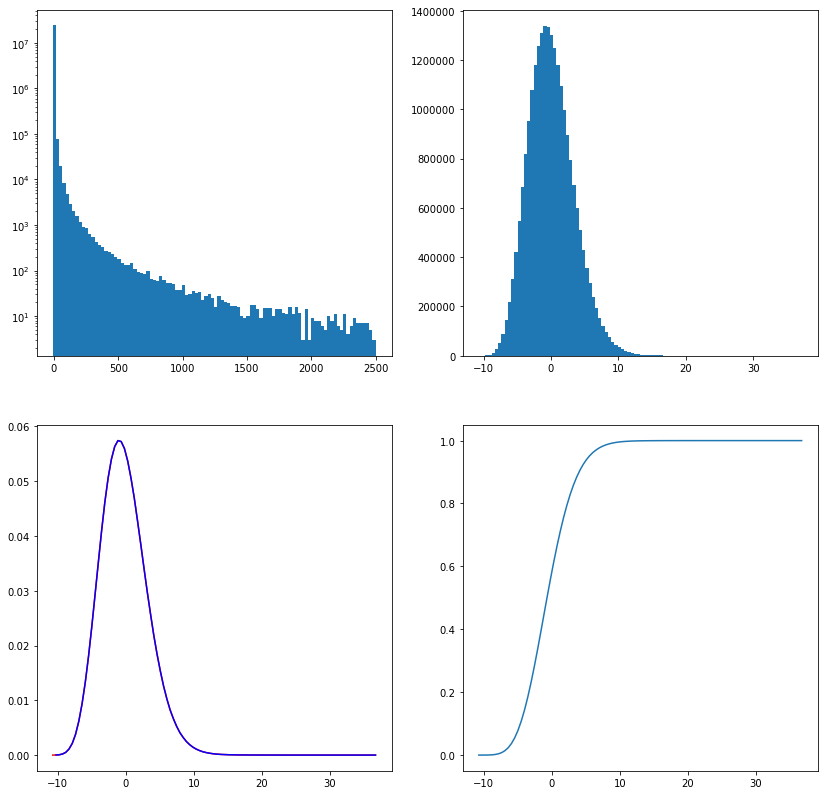

In [7]:
%%time

gamma_file_path =  "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/proton/proton_20deg_0deg_run50001___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"

plot_all_and_save_cdf(gamma_file_path,
                      tel_id_filter_list=list(range(9, 43)) + list(range(111, 116)),
                      channel_threshold=None,
                      cam_id="FlashCam",
                      json_file_path="flashcam_grid_prod3b_north_cdf.json",
                      max_num_samples=MAX_NUM_SAMPLES)

## LSTcam

### Grid Prod3b North

Dragoncam = "LSTCam" (tel 1 to 8 in prod3b - North site (LaPalma)), 2 channels

Cam ID: LSTCam
Simtel file: /Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz
Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8]
Num samples: 18459105
Memory usage for sig_sample_array: 73.83642 Mb
Memory usage for noise2_sample_array: 142.684472 Mb
Noise: Mean = 0.005859493651588297 ; Std = 1.6955332440402968
Min: -3.63517203441
Max: 30.9209311345
CPU times: user 9min 5s, sys: 19.4 s, total: 9min 24s
Wall time: 11min 7s


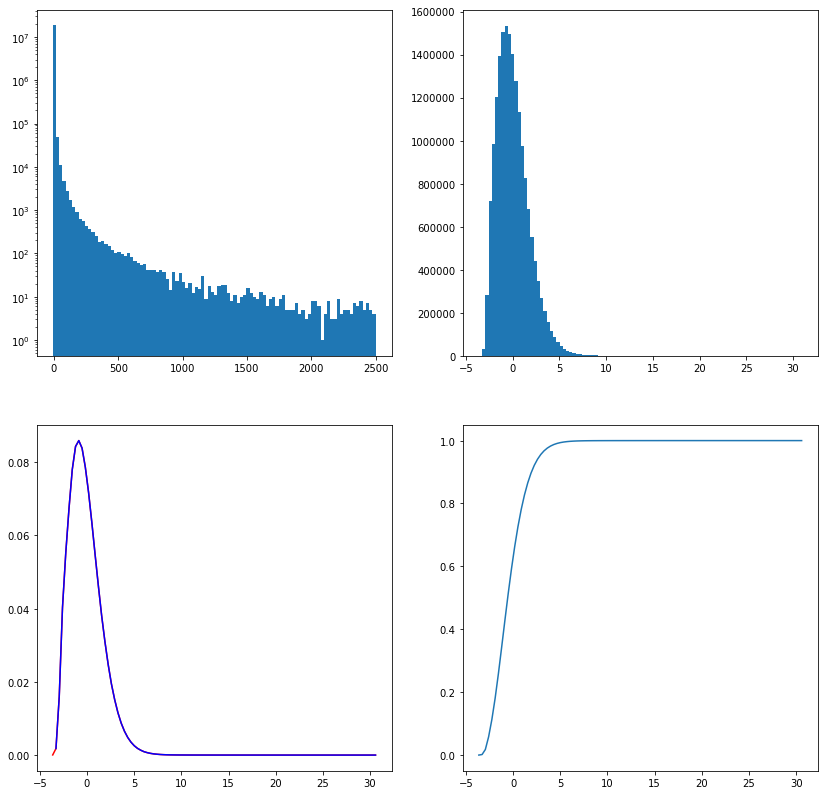

In [8]:
%%time

channel_threshold = 100

gamma_file_path =  "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/proton/proton_20deg_0deg_run50001___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"

plot_all_and_save_cdf(gamma_file_path,
                      tel_id_filter_list=list(range(1, 9)),
                      channel_threshold=channel_threshold,
                      cam_id="LSTCam",
                      json_file_path="lstcam_grid_prod3b_north_cdf.json",
                      max_num_samples=MAX_NUM_SAMPLES)

## NectarCam

### Grid Prod3b North

Nectarcam = "NectarCam" (tel 43 to 76 and 116 to 120 in prod3b - North site (LaPalma)), 2 channels

Cam ID: NectarCam
Simtel file: /Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz
Tel ID range: [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 116, 117, 118, 119, 120]
Num samples: 27198010
Memory usage for sig_sample_array: 108.79204 Mb
Memory usage for noise2_sample_array: 210.068872 Mb
Noise: Mean = 0.004014534324524224 ; Std = 1.5878210626759197
Min: -3.60999923497
Max: 33.4041563321
CPU times: user 14min 55s, sys: 1min 17s, total: 16min 13s
Wall time: 17min 59s


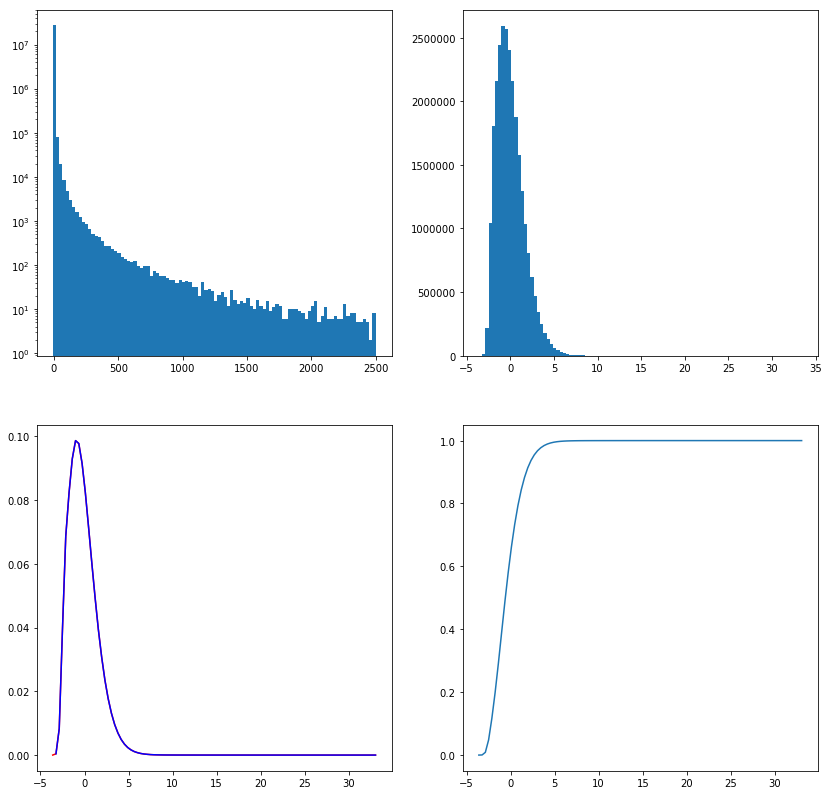

In [9]:
%%time

channel_threshold = 190

gamma_file_path =  "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/proton/proton_20deg_0deg_run50001___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"

plot_all_and_save_cdf(gamma_file_path,
                      tel_id_filter_list=list(range(43, 77)) + list(range(116, 121)),
                      channel_threshold=channel_threshold,
                      cam_id="NectarCam",
                      json_file_path="nectarcam_grid_prod3b_north_cdf.json",
                      max_num_samples=MAX_NUM_SAMPLES)

## Inverse transform sampling with spline interpolation

But: construire une distribution à partir d'un modèle empirique ("inverse transform sampling").

Implémentation en Python:
* http://www.astroml.org/book_figures/chapter3/fig_clone_distribution.html
* https://github.com/astroML/astroML/blob/master/astroML/density_estimation/empirical.py
* https://github.com/astroML/astroML/blob/0287fe00c429b28b3ddf52435a32543f43246349/astroML/density_estimation/tests/test_empirical.py
* http://www.astroml.org/modules/generated/astroML.density_estimation.EmpiricalDistribution.html#astroML.density_estimation.EmpiricalDistribution
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splprep.html
* https://docs.scipy.org/doc/scipy/reference/interpolate.html

* https://en.wikipedia.org/wiki/Inverse_transform_sampling


Mon implémentation:

* Ne pas garder tous les points comme ils le font dans astroml (j'ai plusieurs centaines de millions se samples...)
* A la place, utiliser np.histogram pour faire un CDF avec un nombre de bins choisi
* Stocker ce CDF dans un fichier
* Ecrire une classe pour générer des echantillons: charger et interpoller (avec des splines) le CDF dans __init__
        interpolate.splrep(y, data)
* Fonction rvs qui génère un echantillon
        interpolate.splev(y, self._tck)

In [181]:
with open("astri_inaf_cdf.json", "r") as fd:
    cdf = json.load(fd)

In [182]:
x_list = cdf['cdf_x']
y_list = cdf['cdf_y']

filtered_x_list = []
filtered_y_list = []

# Dirty hack to stightly improve the spline interpolation at the border of the range
filtered_x_list.append(x_list[1] + x_list[1] - x_list[0])
filtered_y_list.append(0.)

# "Clean" data to have an actual inverse CDF (i.e. lets the CDF be *strictly* increasing)
for i, (xip, xi, yip, yi) in enumerate(zip(x_list[0:-1], x_list[1:], y_list[0:-1], y_list[1:])):
    if yi <= yip:
        print("Error at index {}: cdf({}) = cdf({}) = {}. Removing this point.".format(i, xip, xi, yi))
    else:
        filtered_x_list.append(x_list[i])
        filtered_y_list.append(y_list[i])

# Dirty hack to stightly improve the spline interpolation at the border of the range
filtered_x_list.append(x_list[-1] + x_list[-1] - x_list[-2])
filtered_y_list.append(1.)

Error at index 90: cdf(4.884885923871503) = cdf(4.951419609058267) = 0.9999997955894153. Removing this point.
Error at index 93: cdf(5.084486979431794) = cdf(5.1510206646185575) = 0.9999999123954637. Removing this point.
Error at index 94: cdf(5.1510206646185575) = cdf(5.217554349805321) = 0.9999999123954637. Removing this point.
Error at index 95: cdf(5.217554349805321) = cdf(5.284088034992085) = 0.9999999123954637. Removing this point.
Error at index 96: cdf(5.284088034992085) = cdf(5.350621720178848) = 0.9999999123954637. Removing this point.


In [183]:
x = np.array(filtered_x_list)
y = np.array(filtered_y_list)

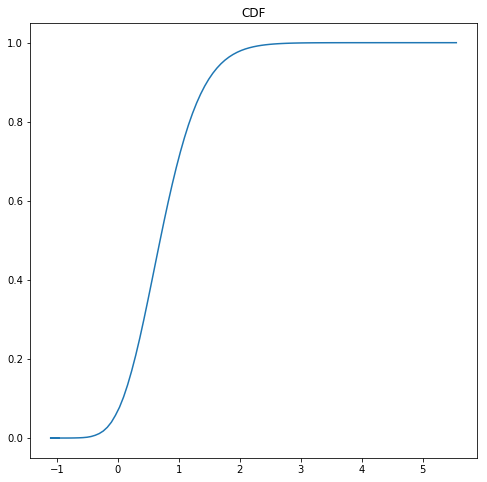

In [184]:
plt.plot(x, y)
plt.title("CDF")

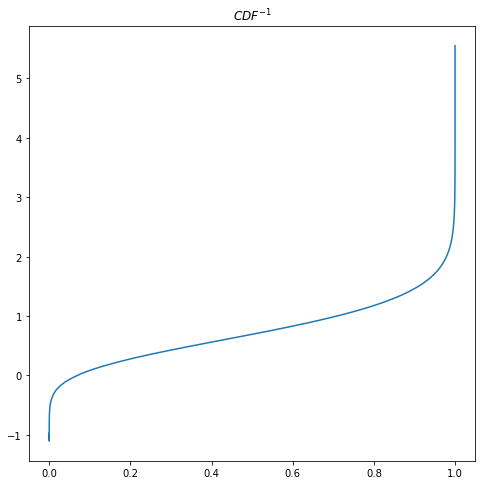

In [185]:
plt.plot(y, x)
plt.title(r"$CDF^{-1}$")

In [186]:
spl = scipy.interpolate.splrep(y, x)

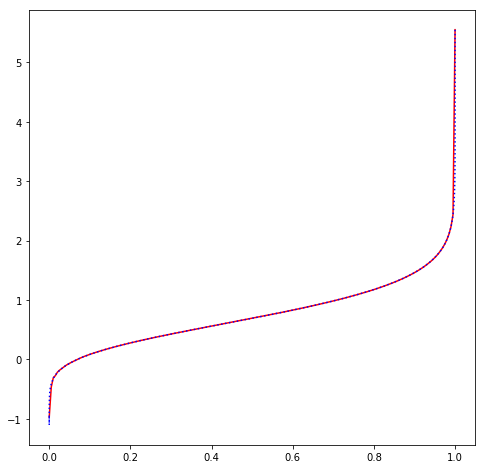

In [187]:
y2 = np.linspace(0., 1., 200)
x2 = scipy.interpolate.splev(y2, spl)

plt.plot(y2, x2, "-r")
plt.plot(y, x, ":b")

In [188]:
def rvs(size):
    y = np.random.random(size)
    return scipy.interpolate.splev(y, spl)

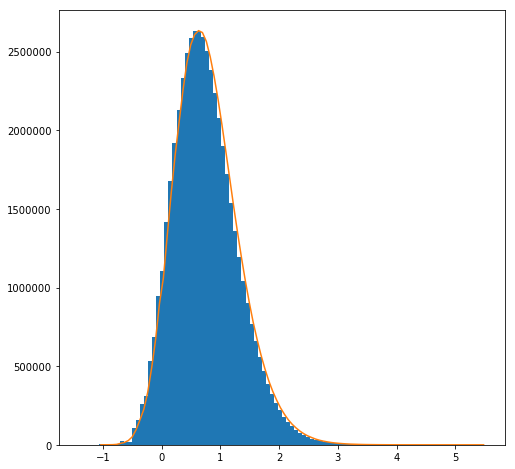

In [189]:
samples = rvs(MAX_NUM_SAMPLES)

n, bins, patches = plt.hist(samples, bins=100,)

cdf_x = np.array(cdf['cdf_x'])
cdf_y = np.array(cdf['cdf_y'])

plt.plot(cdf_x[1:], np.diff(cdf_y) / np.diff(cdf_y).max() * n.max());